In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import matplotlib.pyplot as plt

In [2]:
btc = yf.download("BTC-USD")
# btc.dropna(inplace=True)

eth = yf.download("ETH-USD")
# gold.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# تاریخ و قیمت بسته‌شده آخرین روز
last_date = btc.index[-1]
last_close_price = btc['Close'].iloc[-1]

print(f"تاریخ آخرین روز: {last_date}")
print(f"قیمت بسته‌شده آخرین روز: {last_close_price}")


تاریخ آخرین روز: 2024-11-18 00:00:00
قیمت بسته‌شده آخرین روز: 91992.4921875


In [4]:

btc['ETH_Close'] = eth['Close'].shift(1)
btc['real_price'] = (btc['Close'].shift(1) - btc['Open'].shift(1))
btc['Tomorrow'] = btc['Close'].shift(-1)

btc['Date'] = btc.index

# تبدیل تاریخ به ویژگی‌های عددی (سال، ماه، روز، روز هفته)
btc['Year'] = btc['Date'].dt.year
btc['Month'] = btc['Date'].dt.month
btc['Day'] = btc['Date'].dt.day
btc['Weekday'] = btc['Date'].dt.weekday

# حذف تاریخ از ویژگی‌ها
btc.drop(columns=['Date'], inplace=True)

btc['SMA_10_eth'] = ta.trend.sma_indicator(eth['Close'], window=10)
btc['EMA_10_eth'] = ta.trend.ema_indicator(eth['Close'], window=10)


btc['SMA_20'] = ta.trend.sma_indicator(btc['Close'], window=20)
btc['EMA_20'] = ta.trend.ema_indicator(btc['Close'], window=20)

btc['Pct_change'] = btc['Close'].pct_change()

# محاسبه باندهای بولینگر
btc['BB_bbm'] = ta.volatility.bollinger_mavg(btc['Close'])
btc['BB_bbh'] = ta.volatility.bollinger_hband(btc['Close'])
btc['BB_bbl'] = ta.volatility.bollinger_lband(btc['Close'])
btc['Lag_1'] = btc['Close'].shift(1)
btc['Lag_3'] = btc['Close'].shift(3)
btc['Lag_5'] = btc['Close'].shift(5)

btc['Close'] = btc['Close'].shift(1)

btc['High'] = btc['High'].shift(1)
btc.dropna(inplace=True)




In [5]:
# تاریخ و قیمت بسته‌شده آخرین روز
last_date = btc.index[-1]
last_close_price = btc['Close'].iloc[-1]

print(f"تاریخ آخرین روز: {last_date}")
print(f"قیمت بسته‌شده آخرین روز: {last_close_price}")


تاریخ آخرین روز: 2024-11-17 00:00:00
قیمت بسته‌شده آخرین روز: 90558.4765625


In [6]:

# تعداد روزهای آینده که می‌خواهید پیش‌بینی کنید
future_days = 5

# جایگزینی مقادیر گم‌شده با میانگین


# ایجاد ستون‌های Tomorrow برای پیش‌بینی
for i in range(1, future_days + 1):
    btc[f'Tomorrow_{i}'] = btc['Close'].shift(-i)

# جدا کردن X و y برای آموزش مدل
y = btc[[f'Tomorrow_{i}' for i in range(1, future_days + 1)]]
X = btc[['Close', 'High', 'ETH_Close', 'real_price', 'SMA_20', 'EMA_20', 'BB_bbm', 'BB_bbh', 'BB_bbl', 'Pct_change', 'Lag_1', 'Lag_3', 'Lag_5', 'SMA_10_eth', 'EMA_10_eth', 'Month', 'Weekday']]


In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



In [8]:
# جایگزینی مقادیر گم‌شده برای X_train و X_test
imputer = SimpleImputer(strategy='mean')

# ایمپوتیشن برای داده‌های آموزش
X_train_imputed = imputer.fit_transform(X_train)

# ایمپوتیشن برای داده‌های تست (استفاده از fit_transform بر روی X_train و transform بر روی X_test)
X_test_imputed = imputer.transform(X_test)


In [9]:
# جایگزینی مقادیر گمشده برای y_train و y_test
y_imputer = SimpleImputer(strategy='mean')
y_train_imputed = y_imputer.fit_transform(y_train)
y_test_imputed = y_imputer.transform(y_test)


In [10]:
# Check for NaN values in X_test
print("NaN values in X_test:")
print(np.any(np.isnan(X_test_imputed)))  # Returns True if NaN is found in X_test
print(np.isnan(X_test_imputed).sum())  # Count of NaN values in X_test

# Check for NaN values in y_test
print("NaN values in y_test:")
print(np.any(np.isnan(y_test_imputed)))  # Returns True if NaN is found in y_test
print(np.isnan(y_test_imputed).sum())  # Count of NaN values in y_test


NaN values in X_test:
False
0
NaN values in y_test:
False
0


In [11]:
scaler = StandardScaler()
X_train_imputed = scaler.fit_transform(X_train)
X_test_imputed = scaler.transform(X_test)

In [12]:
model = MLPRegressor(hidden_layer_sizes=(128,64,32,16), max_iter=1000, solver='adam',max_fun=21000, activation='relu', learning_rate='invscaling')
model.fit(X_train_imputed, y_train_imputed)
print(model.score(X_test_imputed, y_test_imputed))
print(model.score(X_train_imputed, y_train_imputed))

0.8781339806926505
0.9931232775757206


In [13]:
y_test_pred = model.predict(X_test_imputed)

In [14]:

rmse = (root_mean_squared_error(y_test_imputed, y_test_pred))
print(f"Root Mean Squared Error: {rmse}")

# پیش‌بینی و ارزیابی مدل
# y_pred = model.predict(X_test_imputed)
mae = (mean_absolute_error(y_test_imputed, y_test_pred))
print(f" Mean absolute Error: {mae}")

Root Mean Squared Error: 5571.8251476099485
 Mean absolute Error: 1842.337044585179


In [15]:
# پیش‌بینی قیمت برای ۵ روز آینده
next_5_days = model.predict([X_test_imputed[-1]])  # پیش‌بینی برای آخرین نمونه در X_test

# تاریخ آخرین روز موجود در داده‌های BTC
last_date = btc.index[-1]  # استفاده از تاریخ آخرین ردیف در دیتافریم BTC

# دریافت قیمت بسته‌شده آخرین روز از داده‌های بیت‌کوین
last_close_price = btc['Close'].iloc[-1]  # قیمت بسته‌شده آخرین روز

# چاپ قیمت واقعی روز آخر
print(f"قیمت واقعی روز آخر: {last_close_price}")

# تاریخ روز پیش‌بینی شده
predicted_day = last_date  # تاریخ پیش‌بینی باید از تاریخ آخرین روز در داده‌های BTC گرفته شود

# چاپ پیش‌بینی‌ها برای ۵ روز آینده
for i in range(5):
    predicted_date = predicted_day + pd.Timedelta(days=i+1)  # تاریخ روزهای پیش‌بینی شده
    predicted_price = next_5_days[0][i]  # پیش‌بینی قیمت برای روز i
    print(f"روز {i+1} - تاریخ: {predicted_date.date()} ، پیش‌بینی قیمت: {predicted_price}")


قیمت واقعی روز آخر: 90558.4765625
روز 1 - تاریخ: 2024-11-18 ، پیش‌بینی قیمت: 90581.9895791656
روز 2 - تاریخ: 2024-11-19 ، پیش‌بینی قیمت: 90439.65214526851
روز 3 - تاریخ: 2024-11-20 ، پیش‌بینی قیمت: 90416.58702288101
روز 4 - تاریخ: 2024-11-21 ، پیش‌بینی قیمت: 90317.24594572587
روز 5 - تاریخ: 2024-11-22 ، پیش‌بینی قیمت: 90193.32865490172


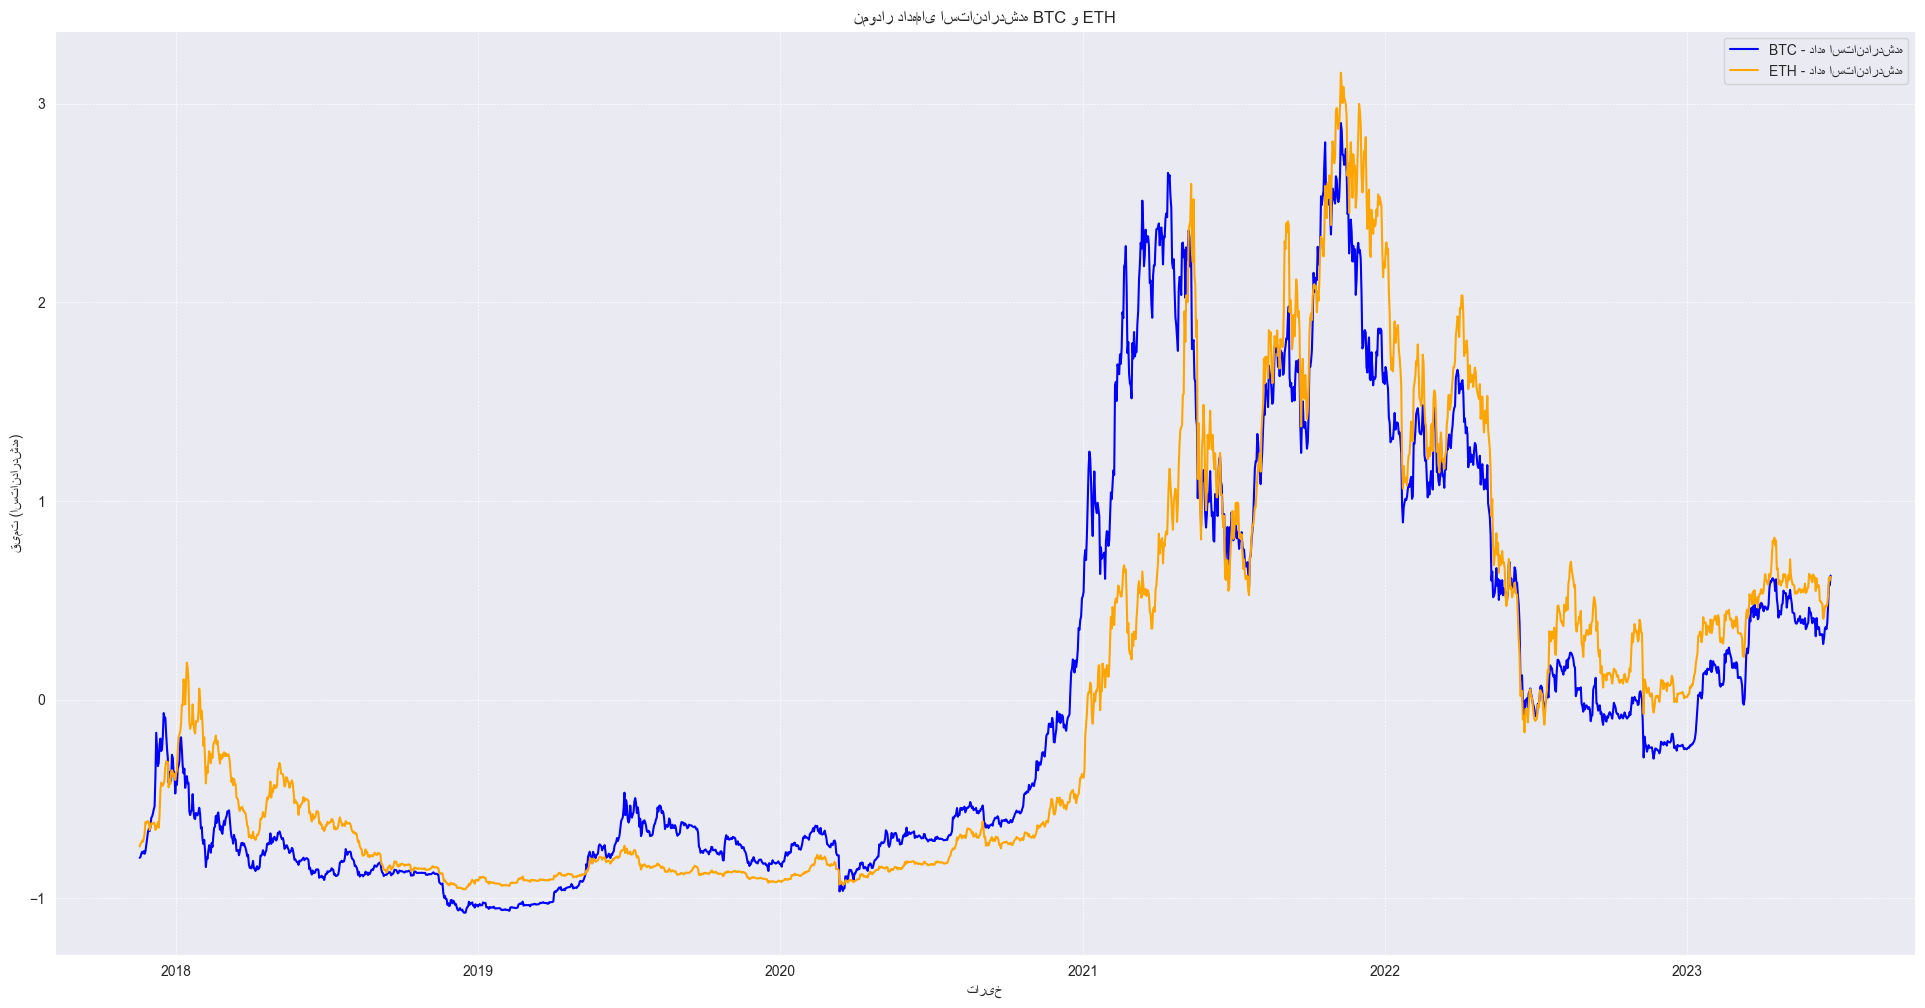

In [16]:
# تبدیل داده‌های استانداردشده به دیتافریم
X_train_df = pd.DataFrame(X_train_imputed, columns=X.columns, index=btc.index[:len(X_train_imputed)])

X_test_df = pd.DataFrame(X_test_imputed, columns=X.columns, index=btc.index[len(X_train_imputed):len(X_train_imputed) + len(X_test_imputed)])

# رسم نمودار با داده‌های استانداردشده
plt.figure(figsize=(24, 12))

# رسم قیمت‌های استانداردشده
plt.plot(X_train_df.index, X_train_df['Close'], color="b", label="BTC - داده استانداردشده")
plt.plot(X_train_df.index, X_train_df['ETH_Close'], color="orange", label="ETH - داده استانداردشده")

# افزودن تنظیمات به نمودار
plt.title('نمودار داده‌های استانداردشده BTC و ETH')
plt.xlabel('تاریخ')
plt.ylabel('قیمت (استانداردشده)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


In [17]:
print(f"Length of X_test_df.index: {len(X_test_df.index)}")
print(f"Length of y_test_imputed: {len(y_test_imputed)}")


Length of X_test_df.index: 512
Length of y_test_imputed: 512


In [18]:
# Convert to numpy arrays if they are not already
X_test_index = np.array(X_test_df.index)
y_test_imputed = np.array(y_test_imputed)

# Ensure they are the same shape and data type
print(f"Shape of X_test_index: {X_test_index.shape}")
print(f"Shape of y_test_imputed: {y_test_imputed.shape}")


Shape of X_test_index: (512,)
Shape of y_test_imputed: (512, 5)


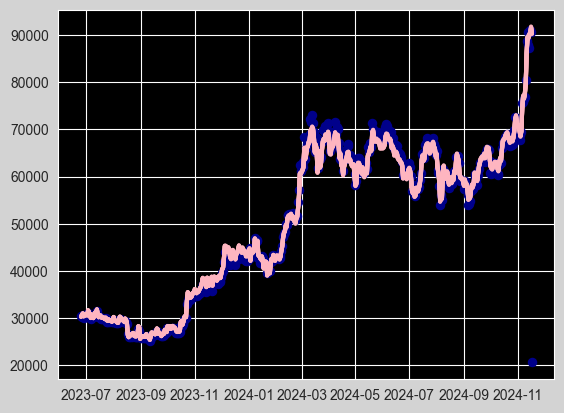

In [19]:
from  matplotlib import rcParams , pyplot
rcParams['figure.facecolor'] = 'lightgray'
pyplot.gcf().set_facecolor('lightgray')
pyplot.gca(). set_facecolor('black')
plt.plot( X_test_df.index,y_test_pred, c='lightpink',alpha=0.9, linewidth=3,drawstyle='default' )
plt.scatter ( X_test_df.index,y_test_imputed[:, 0], alpha=1, s=34, c= 'darkblue' )
plt.show()

In [20]:
import datetime
last_date = btc.index[-1]
print(f"تاریخ آخرین نمونه در داده‌ها: {last_date}")
datetime.date.today() 

تاریخ آخرین نمونه در داده‌ها: 2024-11-17 00:00:00


datetime.date(2024, 11, 18)